# Previsão de custos médicos com Machine Learning

## 1. Contexto do problema
As seguradoras de saúde precisam prever com precisão os custos médicos individuais para definir prêmios de seguro justos e competitivos. Este projeto utiliza um conjunto de dados com informações demográficas e de saúde para desenvolver um modelo preditivo capaz de estimar as despesas médicas anuais de novos clientes.

## 2. Objetivo
Criar e comparar modelos de Regressão (Linear e Random Forest) para prever a variável **`charges`** (custos médicos), identificando quais fatores (idade, IMC, tabagismo, etc.) mais impactam no aumento desses custos.

## 3. Sobre os dados
O dataset contém **1.338 registros** e 7 colunas:
* **age**: idade do beneficiário.
* **sex**: gênero (female/male).
* **bmi**: Índice de Massa Corporal (IMC).
* **children**: número de filhos cobertos pelo seguro.
* **smoker**: se é fumante ou não.
* **region**: região de residência nos EUA.
* **charges**: custos médicos individuais (Variável alvo).

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
# Configuração de estilo para os gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Carregando o conjunto de dados
df = pd.read_csv('/Users/felipesilveira/VSC/Insurance/data/insurance.csv')

## EDA - Análise Exploratória de Dados

In [4]:
# Primeiras linhas
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [5]:
# Informações gerais
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [6]:
# Estatísticas descritivas
print(df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [7]:
# Verificando valores nulos
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


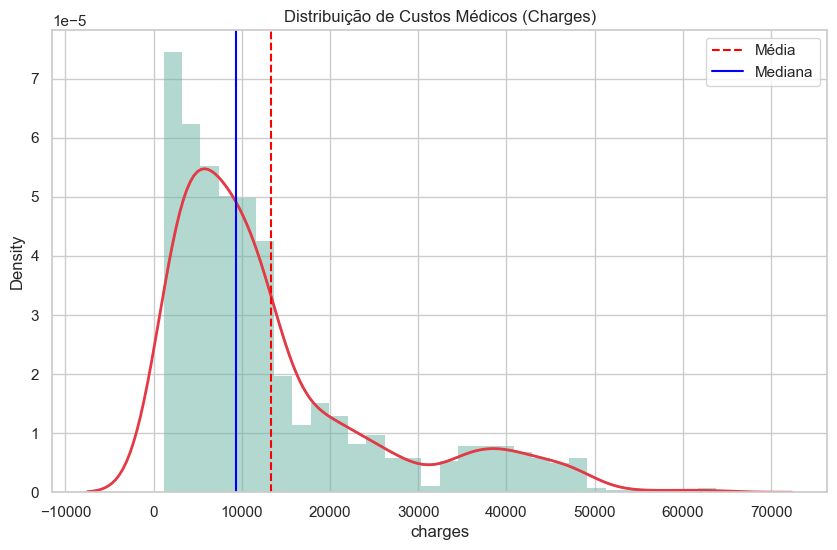

In [8]:
# Distribuição da variável alvo 'charges'
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True, color="#69b3a2", stat="density", linewidth=0)
sns.kdeplot(df['charges'], color="#e63946", linewidth=2)
plt.axvline(df['charges'].mean(), color='red', linestyle='--', label='Média')
plt.axvline(df['charges'].median(), color='blue', linestyle='-', label='Mediana')
plt.title('Distribuição de Custos Médicos (Charges)')
plt.legend()
plt.show()

In [9]:
# Métricas de assimetria e curtose
print(f"Assimetria (Skewness): {stats.skew(df['charges']):.4f}")
print(f"Curtose (Kurtosis): {stats.kurtosis(df['charges']):.4f}")

Assimetria (Skewness): 1.5142
Curtose (Kurtosis): 1.5958


### Insights da distribuição de custos
A análise da variável alvo `charges` revela uma distribuição **assimétrica à direita** (Skewness positiva de ~1.51).
* **Observação**: a maioria dos beneficiários tem custos médicos abaixo de $15.000, mas há uma cauda longa de valores altos, indicando casos extremos que podem ser influenciados por doenças graves ou outros fatores de risco.

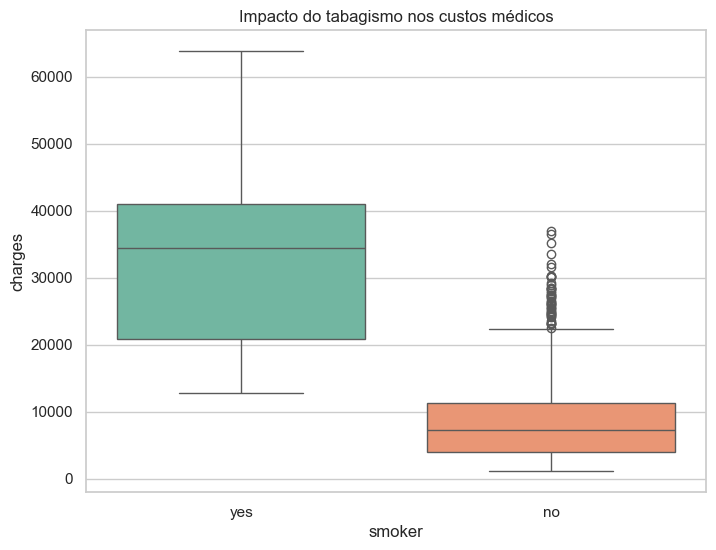

In [10]:
# Boxplot: impacto do tabagismo nos custos médicos
plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='charges', data=df, palette="Set2")
plt.title('Impacto do tabagismo nos custos médicos')
plt.show()

<Figure size 1000x600 with 0 Axes>

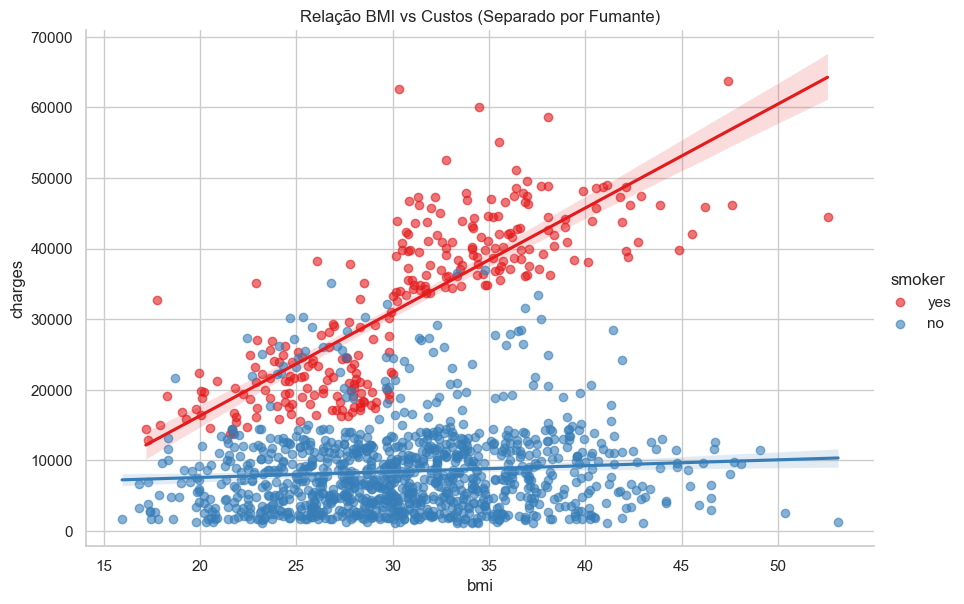

In [11]:
# Scatterplot: Interação BMI e Fumante
plt.figure(figsize=(10, 6))
sns.lmplot(x='bmi', y='charges', hue='smoker', data=df, palette='Set1', height=6, aspect=1.5, scatter_kws={'alpha':0.6})
plt.title('Relação BMI vs Custos (Separado por Fumante)')
plt.show()

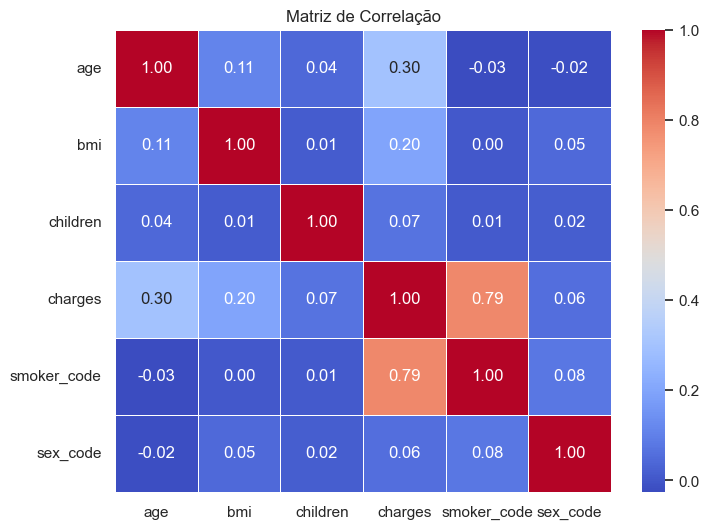

In [12]:
# Matriz de correlação
df_corr = df.copy()
df_corr['smoker_code'] = df_corr['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
df_corr['sex_code'] = df_corr['sex'].apply(lambda x: 1 if x == 'male' else 0)
corr = df_corr.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

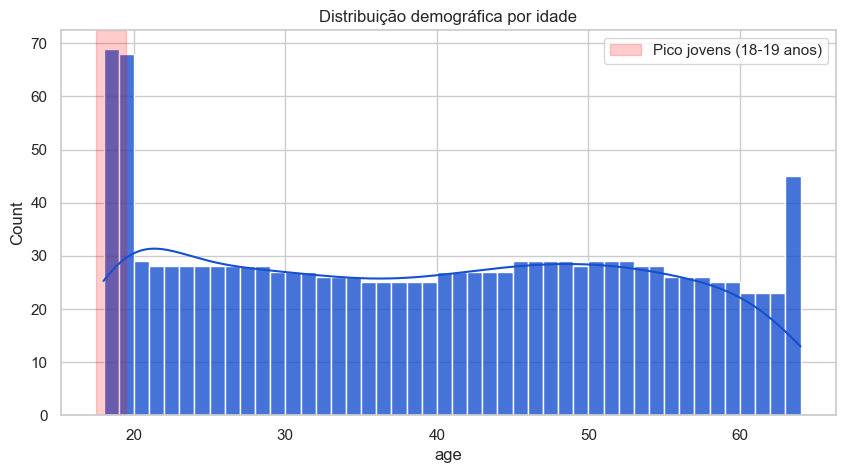

In [13]:
# Distribuição demográfica(Idade)
plt.figure(figsize=(10, 5))
sns.histplot(df['age'], bins=range(18, 65), kde=True, color="#1650CF", alpha=0.8)
plt.axvspan(17.5, 19.5, color='red', alpha=0.2, label='Pico jovens (18-19 anos)')
plt.title('Distribuição demográfica por idade')
plt.legend()
plt.show()

In [ ]:
# Comparativo gênero (Idade e BMI)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.kdeplot(data=df, x='age', hue='sex', fill=True, common_norm=False, palette='coolwarm', ax=axes[0])
axes[0].set_title('Distribuição de Idade por Gênero')

sns.kdeplot(data=df, x='bmi', hue='sex', fill=True, common_norm=False, palette='coolwarm', ax=axes[1])
axes[1].set_title('Distribuição de BMI por Gênero')
plt.tight_layout()
plt.show()

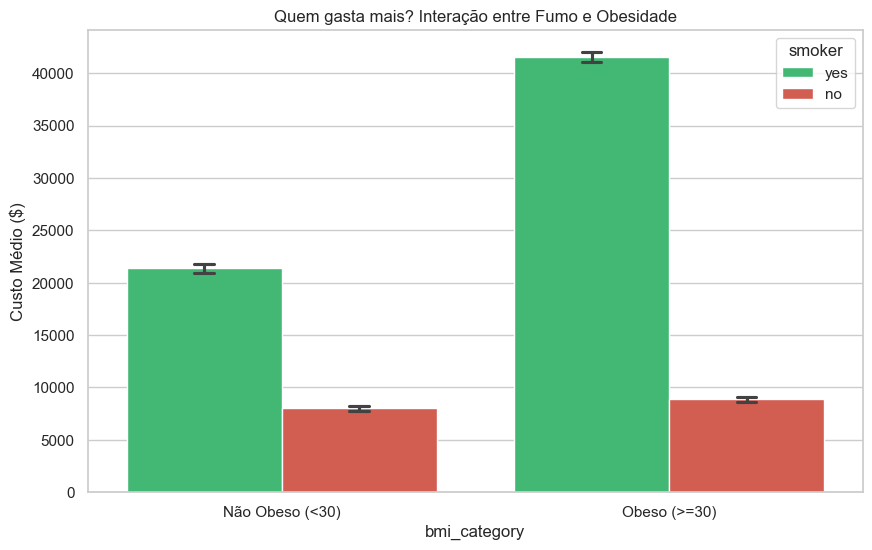

In [16]:
# Interação fumo + obesidade nos custos médicos
df['bmi_category'] = df['bmi'].apply(lambda x: 'Obeso (>=30)' if x >= 30 else 'Não Obeso (<30)')

plt.figure(figsize=(10, 6))
sns.barplot(x='bmi_category', y='charges', hue='smoker', data=df, palette=['#2ecc71', '#e74c3c'], ci=68, capsize=0.1)
plt.title('Quem gasta mais? Interação entre Fumo e Obesidade')
plt.ylabel('Custo Médio ($)')
plt.show()

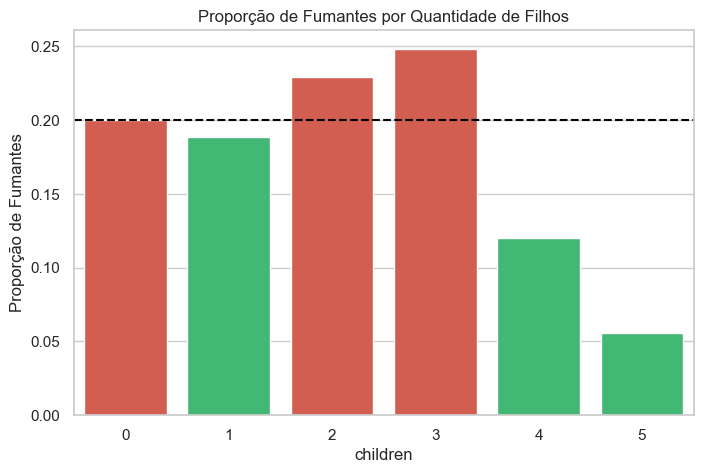

In [17]:
# Interação filhos e fumo nos custos médicos
df['smoker_num'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
smoker_by_children = df.groupby('children')['smoker_num'].mean().reset_index()

plt.figure(figsize=(8, 5))
colors = ['#e74c3c' if x > 0.2 else '#2ecc71' for x in smoker_by_children['smoker_num']]
sns.barplot(x='children', y='smoker_num', data=smoker_by_children, palette=colors)
plt.axhline(0.2, color='black', linestyle='--')
plt.title('Proporção de Fumantes por Quantidade de Filhos')
plt.ylabel('Proporção de Fumantes')
plt.show()

In [18]:
# Teste estatístico (T-Test) entre fumantes e não fumantes
smoker_yes = df[df['smoker'] == 'yes']['charges']
smoker_no = df[df['smoker'] == 'no']['charges']
t_stat, p_val = stats.ttest_ind(smoker_yes, smoker_no)
print(f"\nTeste T (Fumantes vs Não Fumantes): P-value = {p_val:.3e}")


Teste T (Fumantes vs Não Fumantes): P-value = 8.271e-283


## Preparação dos dados para modelagem

In [19]:
# Separando features e target
X = df.drop(columns=['charges', 'bmi_category', 'smoker_num'])
y = df['charges']

In [20]:
# Identificando colunas numéricas e categóricas
num_features = ['age', 'bmi', 'children']
cat_features = ['sex', 'smoker', 'region']

In [21]:
# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ])

In [22]:
# Divisão treino/teste( 80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Pré-processamento dos dados
Para preparar os dados para os algoritmos de Machine Learning:
1. **Tratamento de Categóricas**: as variáveis `sex`, `smoker` e `region` foram convertidas usando **OneHotEncoder**, pois os modelos matemáticos requerem entradas numéricas.
2. **Escalonamento**: aplicamos **StandardScaler** nas variáveis numéricas para garantir que a escala (ex: idade vs salário) não enviese o modelo linear.

## Modelagem e Avaliação

In [23]:
# Modelo de Regressão Linear
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

In [24]:
# Modelo de Random Forest
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [25]:
# Função para calcular métricas de avaliação
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - MAE: {mae:.2f}, R²: {r2:.4f}, RMSE: {rmse:.2f}")

evaluate_model(y_test, y_pred_lr, "Regressão Linear")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")

Regressão Linear - MAE: 4181.19, R²: 0.7836, RMSE: 5796.28
Random Forest Regressor - MAE: 2544.14, R²: 0.8656, RMSE: 4567.76


## Avaliação dos Modelos

Foram testados dois algoritmos principais. Abaixo, os resultados de performance nos dados de teste:

| Modelo | R² Score | RMSE (Erro Médio) |
| :--- | :---: | :---: |
| **Regressão Linear** | *0.7836* | *5796.28* |
| **Random Forest** | *0.8656* | *4567.76* |

> **Conclusão da Modelagem**: o modelo **Random Forest** apresentou melhor desempenho, conseguindo explicar cerca de **86%** da variância dos custos médicos, superando a Regressão Linear por capturar relações não-lineares nos dados.

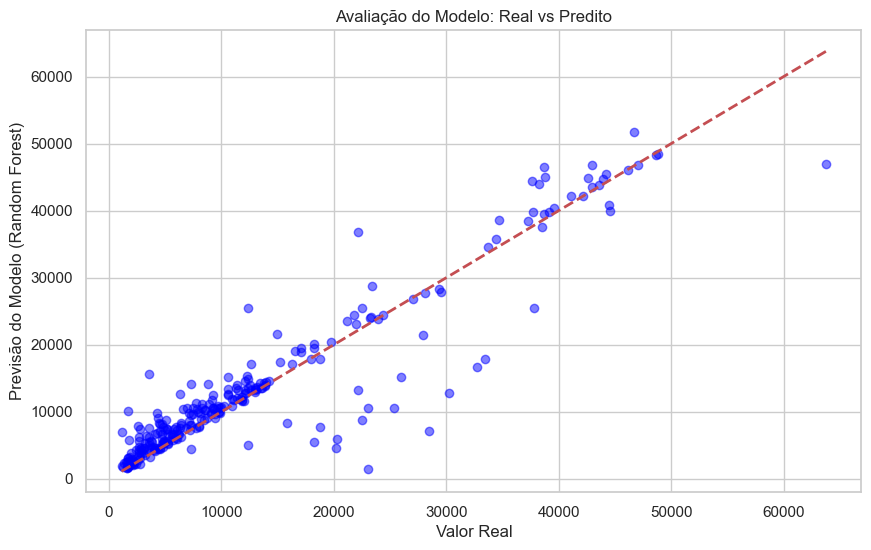

In [26]:
# Gráfico de comparação entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Previsão do Modelo (Random Forest)')
plt.title('Avaliação do Modelo: Real vs Predito')
plt.show()

In [27]:
# Importância das features no modelo Random Forest
ohe_features = model_rf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_features)
all_features = num_features + list(ohe_features)

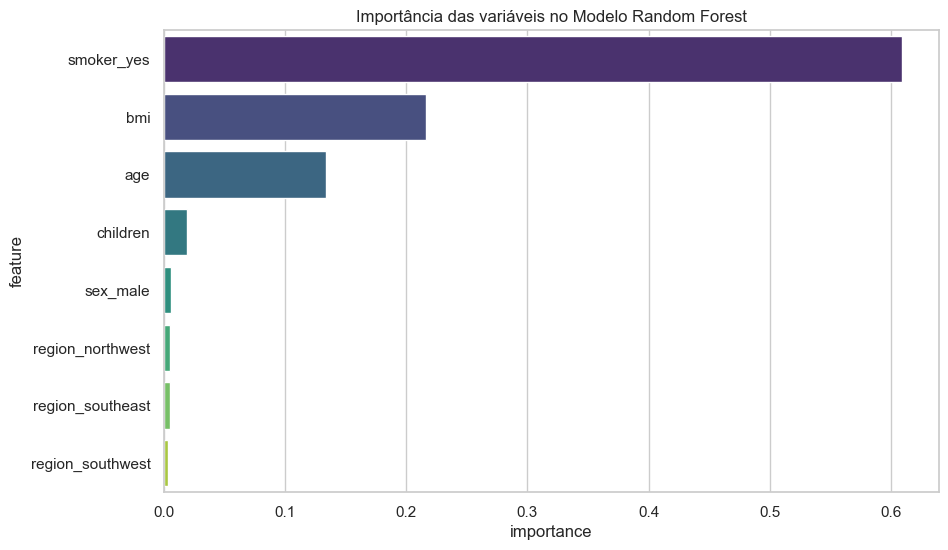

In [28]:
# Extraindo importâncias
importances = model_rf.named_steps['regressor'].feature_importances_
df_imp = pd.DataFrame({'feature': all_features, 'importance': importances})
df_imp = df_imp.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_imp, palette='viridis')
plt.title('Importância das variáveis no Modelo Random Forest')
plt.show()

# Conclusão e Impacto no negócio

A análise de importância das variáveis (Feature Importance) do nosso melhor modelo revelou os principais impulsionadores de custos:

1. **Tabagismo (`smoker`)**: é, de longe, o fator mais determinante. Fumantes custam significativamente mais à seguradora.
2. **IMC (`bmi`)**: o índice de massa corporal tem alta correlação com custos, especialmente quando combinado com o tabagismo.
3. **Idade**: o custo tende a subir linearmente com a idade.

### Próximos Passos
* **Estratégia**: A seguradora deve focar em programas de cessação do tabagismo e controle de peso, pois reduzir esses fatores de risco pode diminuir drasticamente os sinistros.